## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

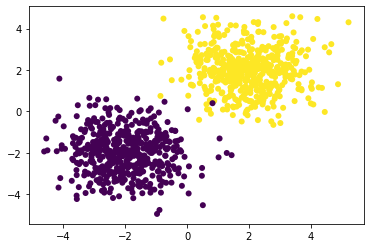

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Dropout(p=0.6))
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 2
LogSoftMax

Linear 2 -> 4
ReLU
Dropout
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

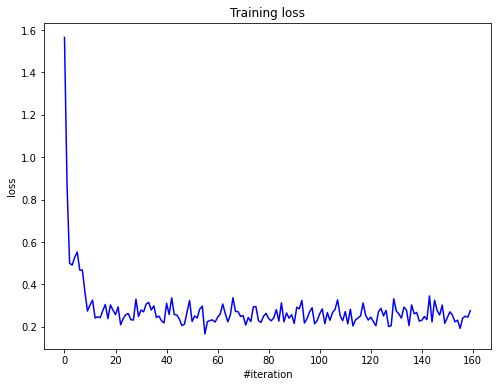

Current loss: 0.276484


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [16]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_val = X_val.reshape((X_val.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

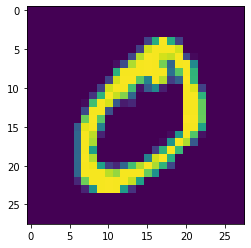

In [17]:
plt.imshow(X_train.reshape((X_train.shape[0], 28, 28))[1])

One-hot encode the labels first.

In [18]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(y_train.reshape(-1, 1))
y_val = enc.transform(y_val.reshape(-1, 1))
y_test = enc.transform(y_test.reshape(-1, 1))

n_classes = y_train.shape[1]
n_features = X_train.shape[1]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [19]:
n_epochs = 40
batch_size = 128
criterion = ClassNLLCriterion()
optimizer = sgd_momentum
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

In [20]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [21]:
def epoch(net, data):
    loss_total = 0
    
    for x_batch, y_batch in get_batches(data, batch_size):
        
        net.zeroGradParameters()

        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        if net.training:
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            optimizer(net.getParameters(), 
                      net.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      
    
        loss_total += loss * x_batch.shape[0]
    return loss_total / data[0].shape[0]

Посмотрим, как ведёт себя loss в зависимости от функции активации и времени работы

In [22]:
from time import time

In [24]:
def show_train(a_func,  batch):
    train_losses = []
    val_losses = []
    
    net = Sequential()
    net.add(Linear(n_features, 10))
    net.add(a_func())
    net.add(Linear(10, 20))
    if batch:
            net.add(BatchNormalization(alpha=0.9))
    net.add(a_func())
    net.add(Linear(20, n_classes))
    net.add(LogSoftMax())
    
    start = time()
    for e in range(n_epochs):
        net.train()
        train_losses.append(epoch(net, (X_train, y_train)))

        net.evaluate()
        val_losses.append(epoch(net, (X_val, y_val)))
    end = time()
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.xlabel("Epoch, n")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    return end - start, train_losses, val_losses

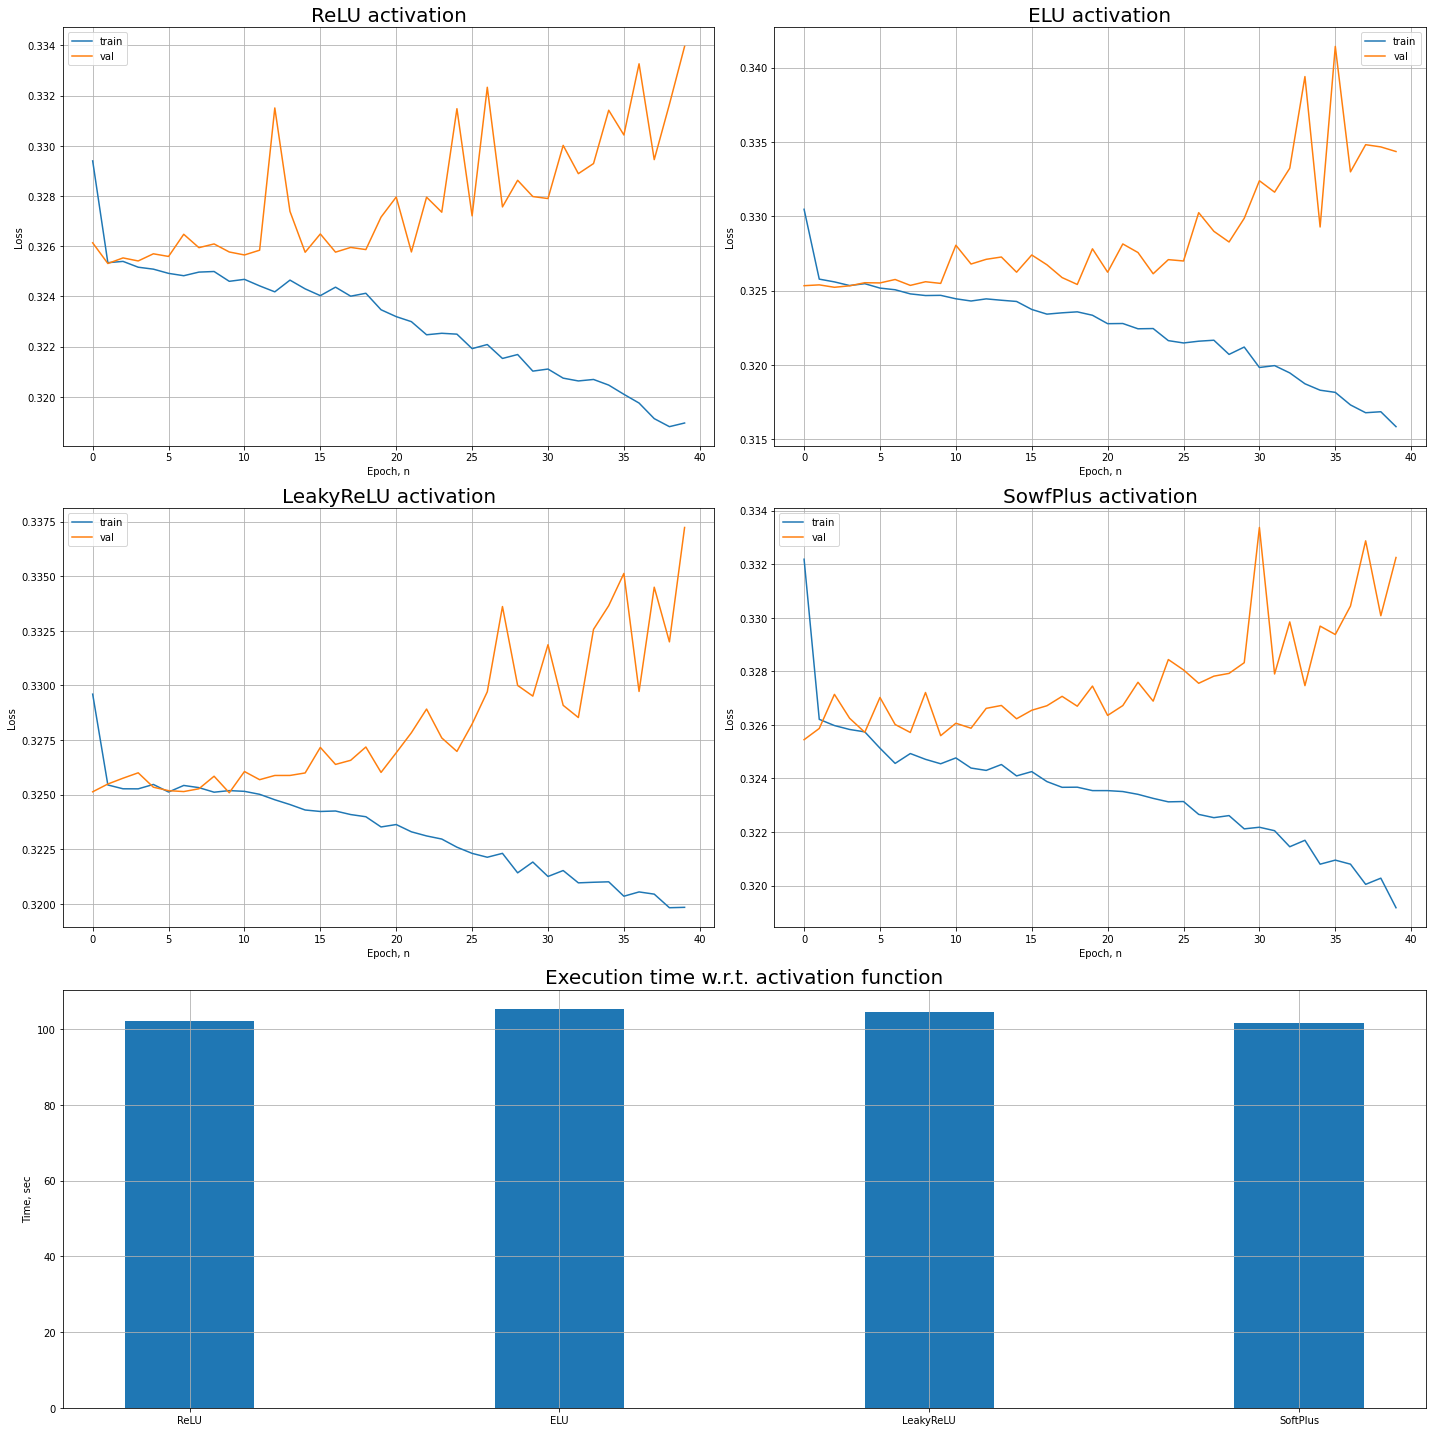

In [25]:
tm = np.array([])
plt.figure(figsize=(20, 20))

# ReLU
plt.subplot(321)
plt.title("ReLU activation", fontsize=20)
t, relu_t, relu_v = show_train(ReLU, False)
tm = np.append(tm, t)

# ELU
plt.subplot(322)
plt.title("ELU activation", fontsize=20)
t, elu_t, elu_v = show_train(ELU, False)
tm = np.append(tm, t)

# LeakyReLU
plt.subplot(323)
plt.title("LeakyReLU activation", fontsize=20)
t, lrelu_t, lrelu_v = show_train(LeakyReLU, False)
tm = np.append(tm, t)

# SoftPlus
plt.subplot(324)
plt.title("SowfPlus activation", fontsize=20)
t, sp_t, sp_v = show_train(SoftPlus, False)
tm = np.append(tm, t)

# time measurements
plt.subplot(313)
plt.title("Execution time w.r.t. activation function", fontsize=20)
plt.bar(['ReLU','ELU', 'LeakyReLU', 'SoftPlus'],
        tm,
        width=0.35)
plt.ylabel('Time, sec')
plt.grid(True)

plt.tight_layout()
plt.show()


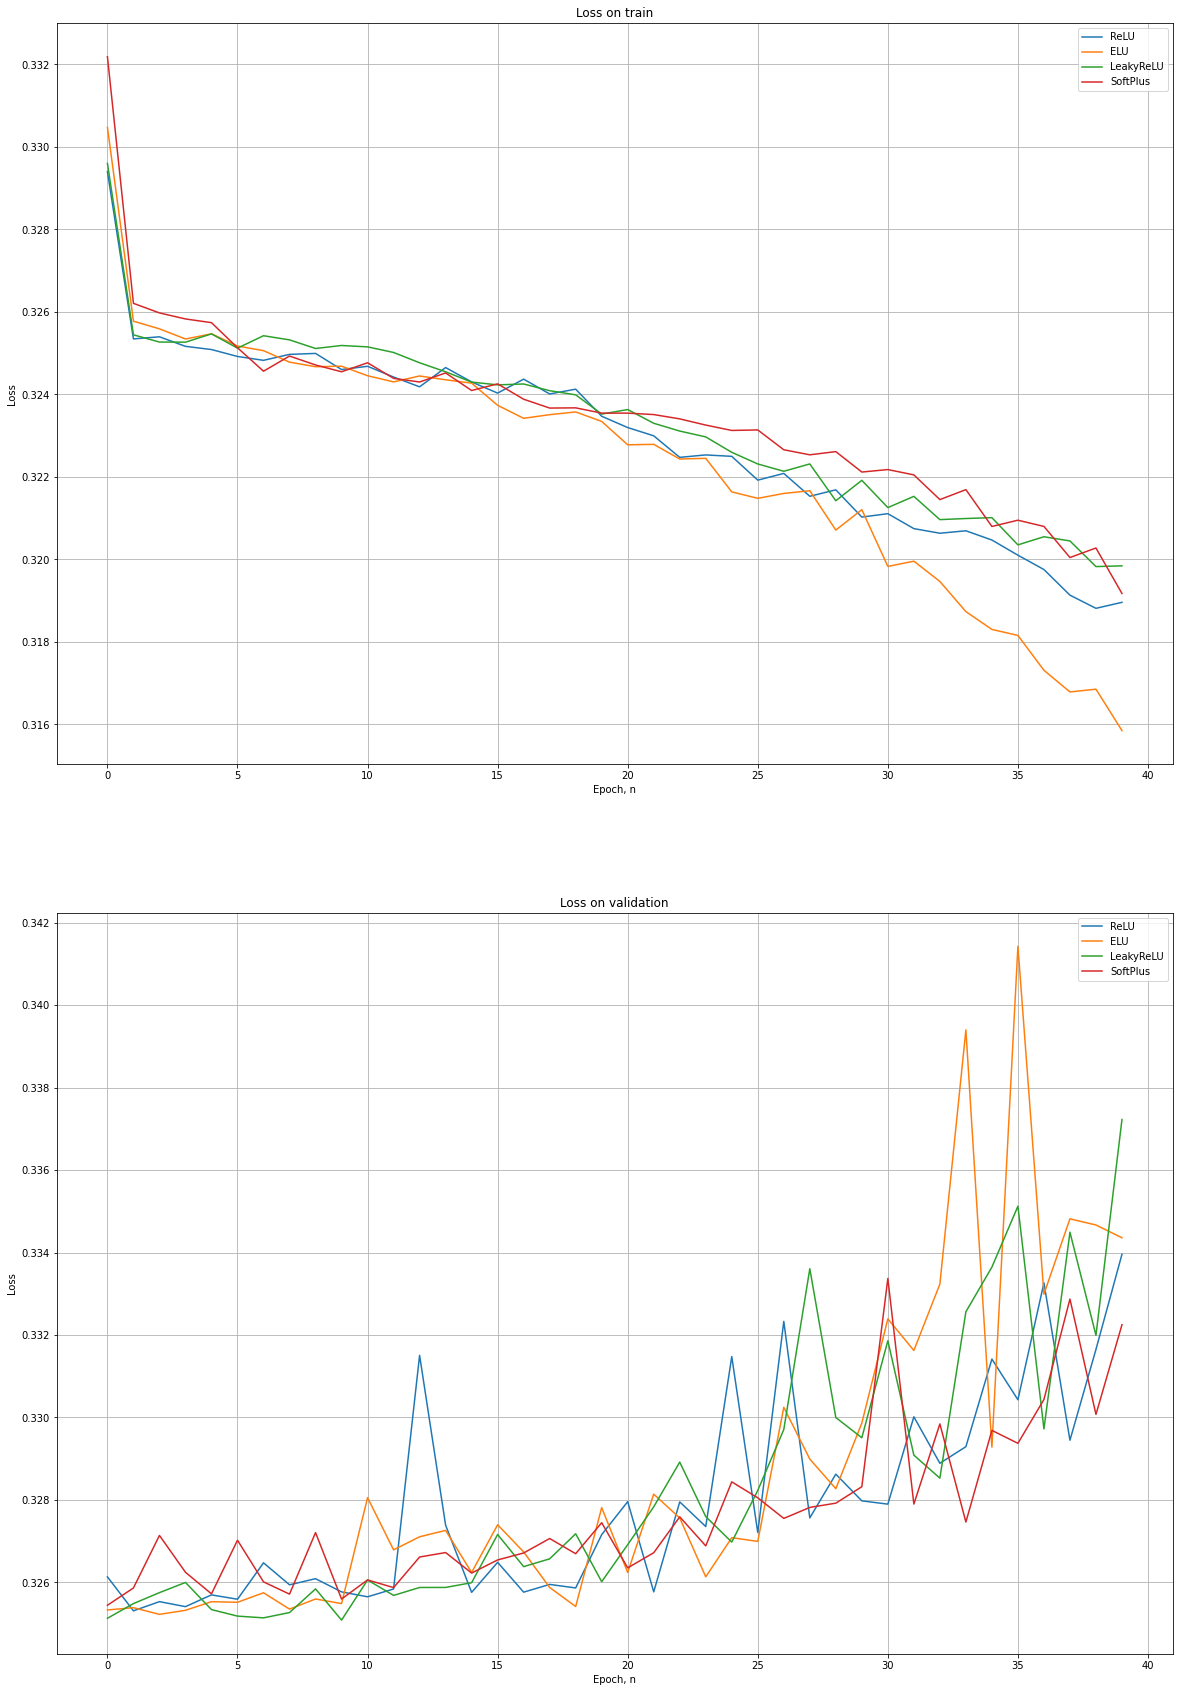

In [27]:
plt.figure(figsize=(20, 30))
plt.subplot(211)
plt.title("Loss on train")
plt.plot(relu_t, label='ReLU')
plt.plot(elu_t, label='ELU')
plt.plot(lrelu_t, label='LeakyReLU')
plt.plot(sp_t, label='SoftPlus')
plt.xlabel('Epoch, n')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.title("Loss on validation")
plt.plot(relu_v, label='ReLU')
plt.plot(elu_v, label='ELU')
plt.plot(lrelu_v, label='LeakyReLU')
plt.plot(sp_v, label='SoftPlus')
plt.xlabel('Epoch, n')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

Попробуем добавить BatchNorm.

In [28]:
def show_train_w_batch(a_func):
    train_losses = []
    val_losses = []
    
    net = Sequential()
    net.add(Linear(n_features, 10))
    net.add(a_func())
    net.add(Linear(10, 20))
    net.add(BatchNormalization())
    net.add(a_func())
    net.add(Linear(20, n_classes))
    net.add(LogSoftMax())
    
    start = time()
    for e in range(n_epochs):
        net.train()
        train_losses.append(epoch(net, (X_train, y_train)))

        net.evaluate()
        val_losses.append(epoch(net, (X_val, y_val)))
    end = time()
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.xlabel("Epoch, n")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    return end - start, train_losses, val_losses

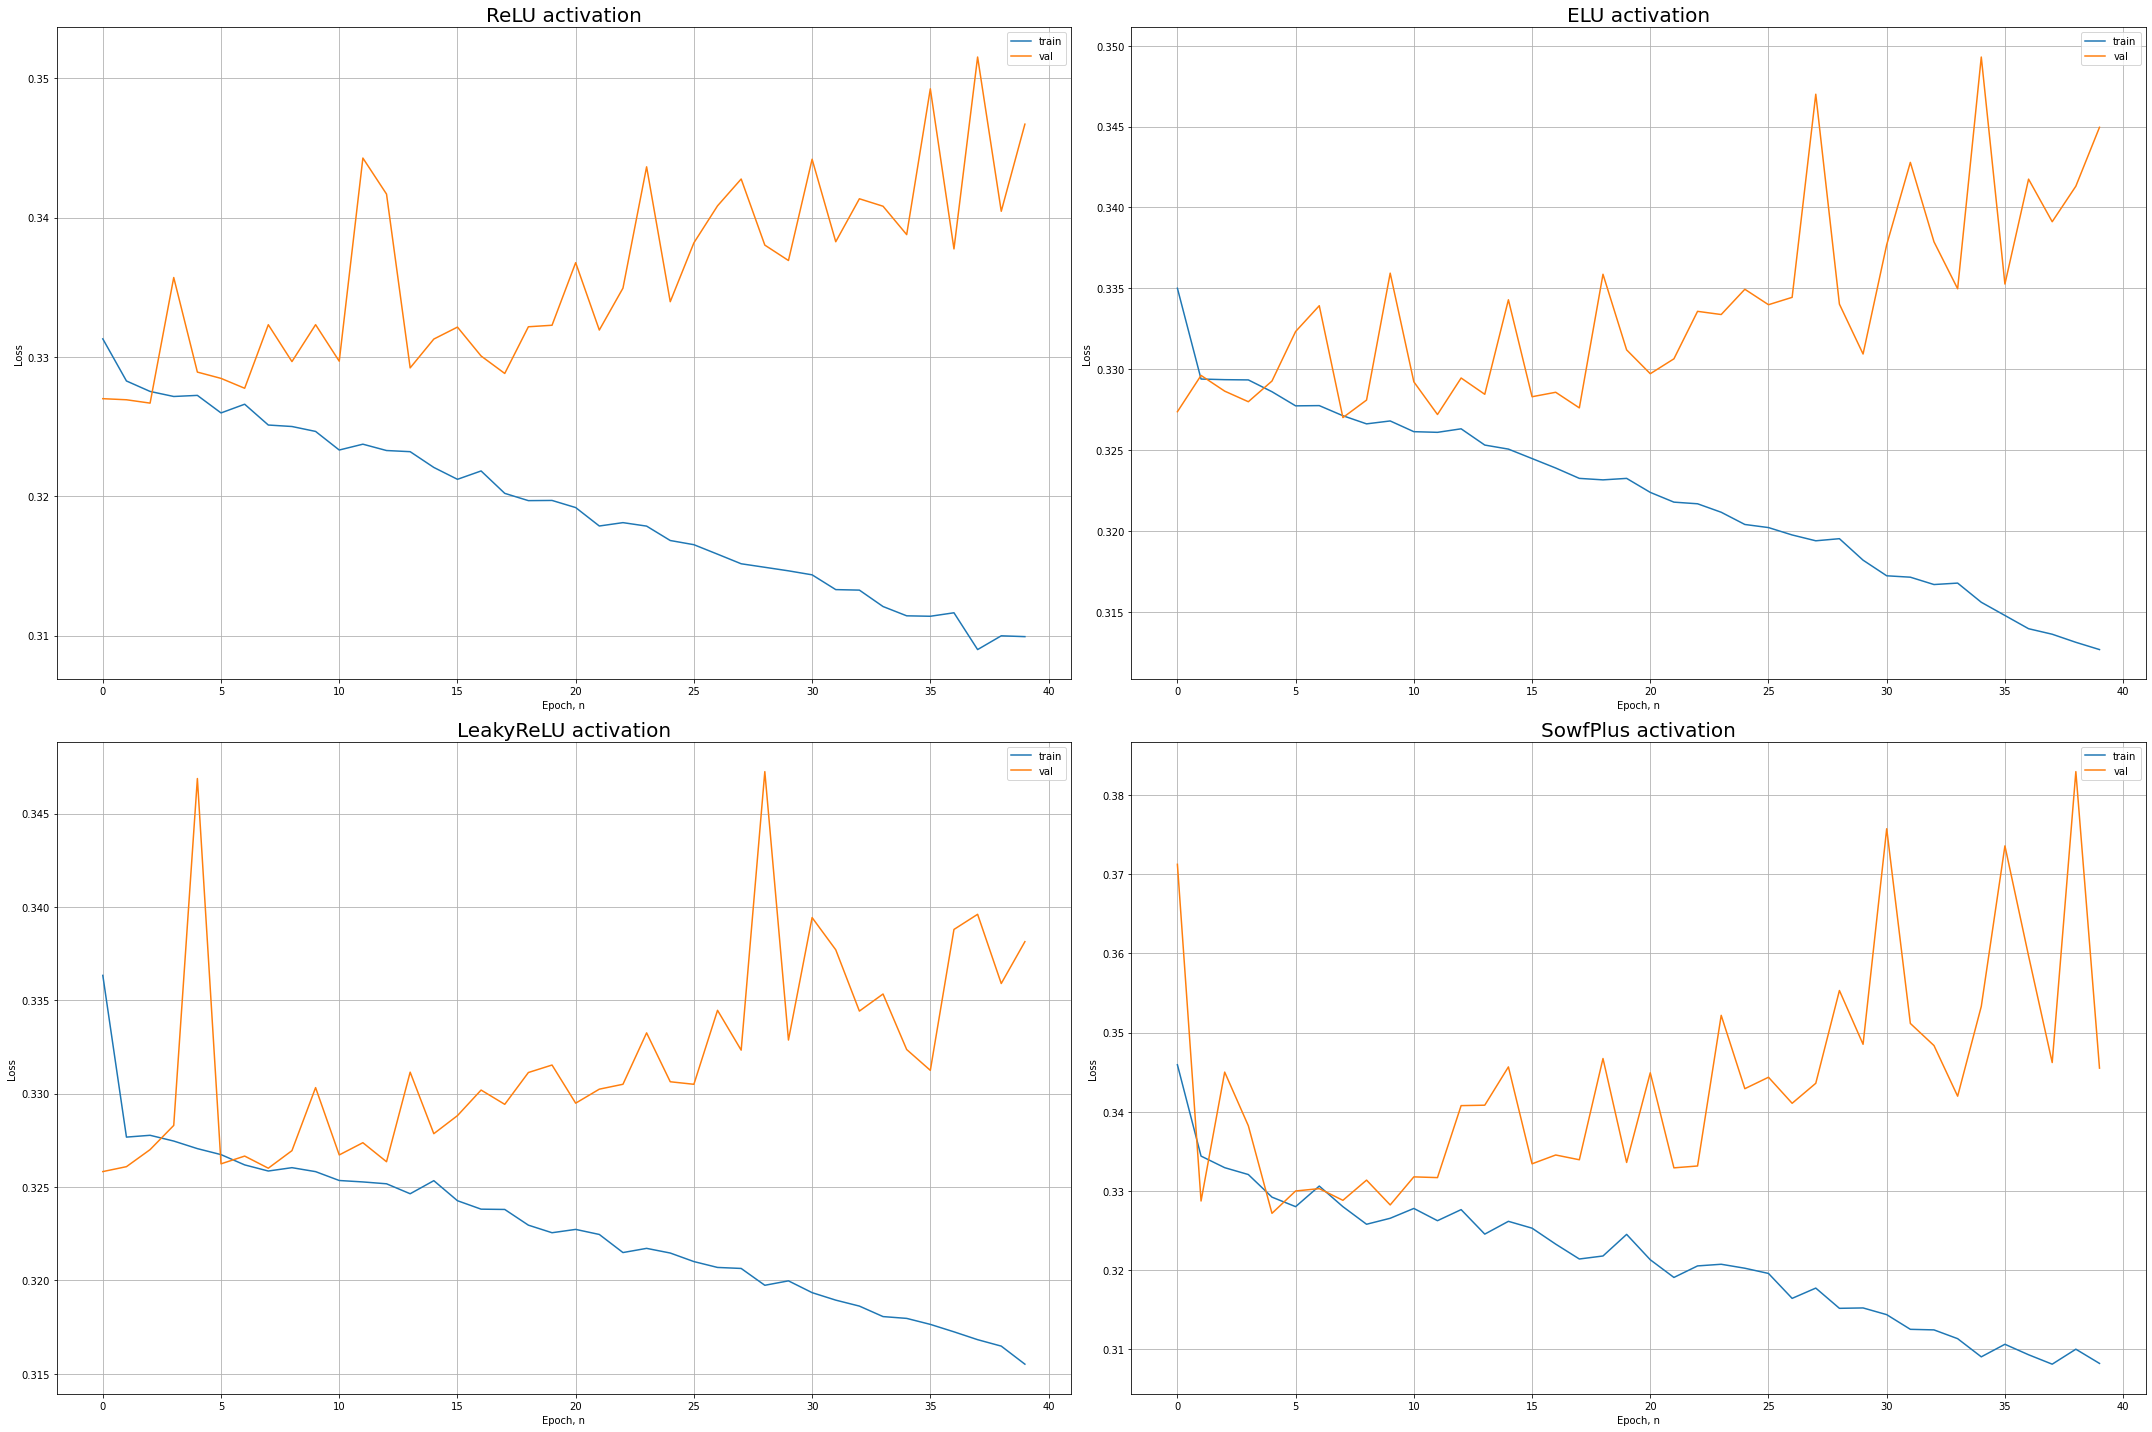

In [29]:
plt.figure(figsize=(30, 20))

# ReLU
plt.subplot(221)
plt.title("ReLU activation", fontsize=20)
t, relu_t_batch, relu_v_batch = show_train_w_batch(ReLU)
tm_batch = np.append(tm, t)

# ELU
plt.subplot(222)
plt.title("ELU activation", fontsize=20)
t, elu_t_batch, elu_v_batch = show_train_w_batch(ELU)
tm_batch = np.append(tm, t)

# LeakyReLU
plt.subplot(223)
plt.title("LeakyReLU activation", fontsize=20)
t, lrelu_t_batch, lrelu_v_batch = show_train_w_batch(LeakyReLU)
tm_batch = np.append(tm, t)

# SoftPlus
plt.subplot(224)
plt.title("SowfPlus activation", fontsize=20)
t, sp_t_batch, sp_v_batch = show_train_w_batch(SoftPlus)
tm_batch = np.append(tm, t)

plt.tight_layout()
plt.show()

Сравним для каждой функции динамику Loss в зависимости от наличия BatchNorm слоя

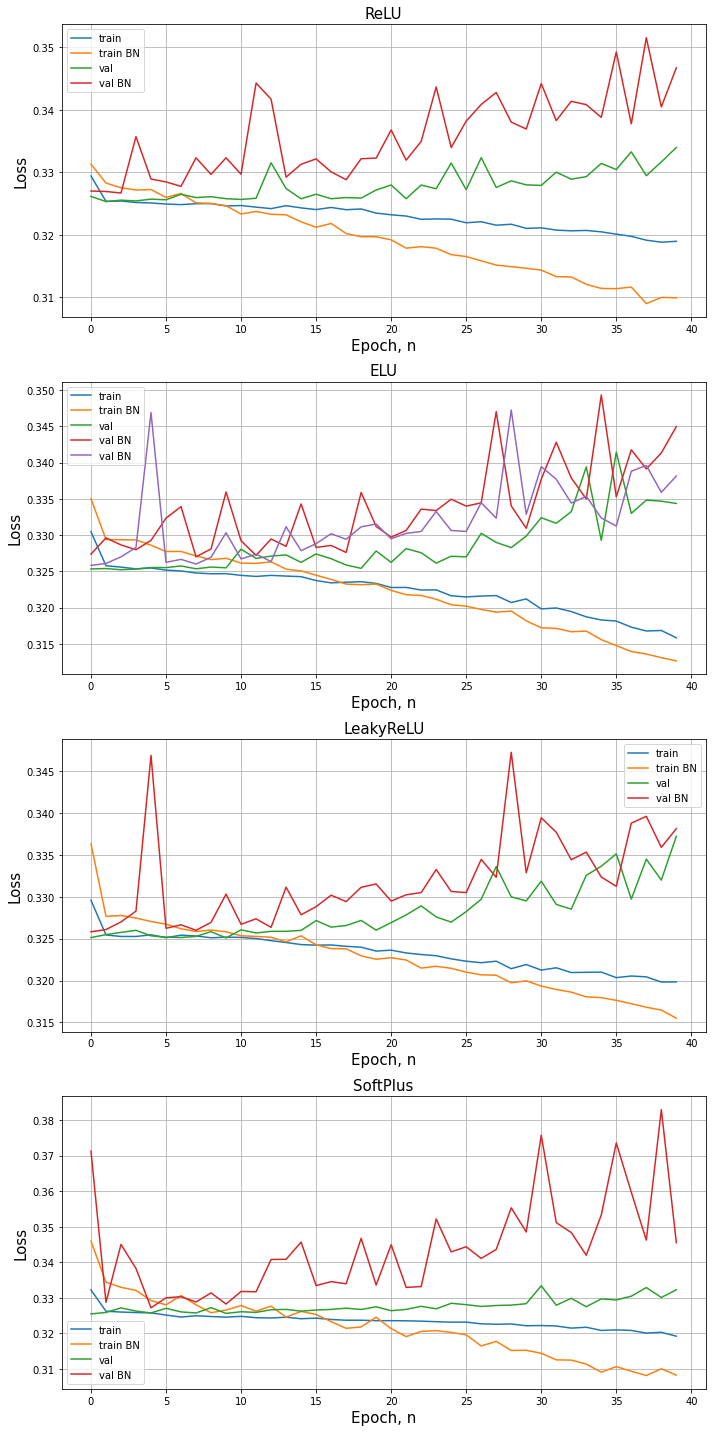

In [31]:
plt.figure(figsize=(10, 20))
plt.subplot(411)
plt.title('ReLU', fontsize=15)
plt.plot(relu_t, label='train')
plt.plot(relu_t_batch, label='train BN')
plt.plot(relu_v, label='val')
plt.plot(relu_v_batch, label='val BN')
plt.xlabel('Epoch, n', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(412)
plt.title('ELU', fontsize=15)
plt.plot(elu_t, label='train')
plt.plot(elu_t_batch, label='train BN')
plt.plot(elu_v, label='val')
plt.plot(elu_v_batch, label='val BN')
plt.plot(lrelu_v_batch, label='val BN')
plt.xlabel('Epoch, n', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(413)
plt.title('LeakyReLU', fontsize=15)
plt.plot(lrelu_t, label='train')
plt.plot(lrelu_t_batch, label='train BN')
plt.plot(lrelu_v, label='val')
plt.plot(lrelu_v_batch, label='val BN')
plt.xlabel('Epoch, n', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(414)
plt.title('SoftPlus', fontsize=15)
plt.plot(sp_t, label='train')
plt.plot(sp_t_batch, label='train BN')
plt.plot(sp_v, label='val')
plt.plot(sp_v_batch, label='val BN')
plt.xlabel('Epoch, n', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

С BatchNorm модели показывают лучший результат.

Сравним gsd с оптимизатором adam.

In [33]:
optimizer = adam_optimizer
optimizer_config = {'learning_rate': 1e-2,
                    'beta1': 0.9, 
                    'beta2':0.999,
                    'epsilon':1e-8}
optimizer_state = {}

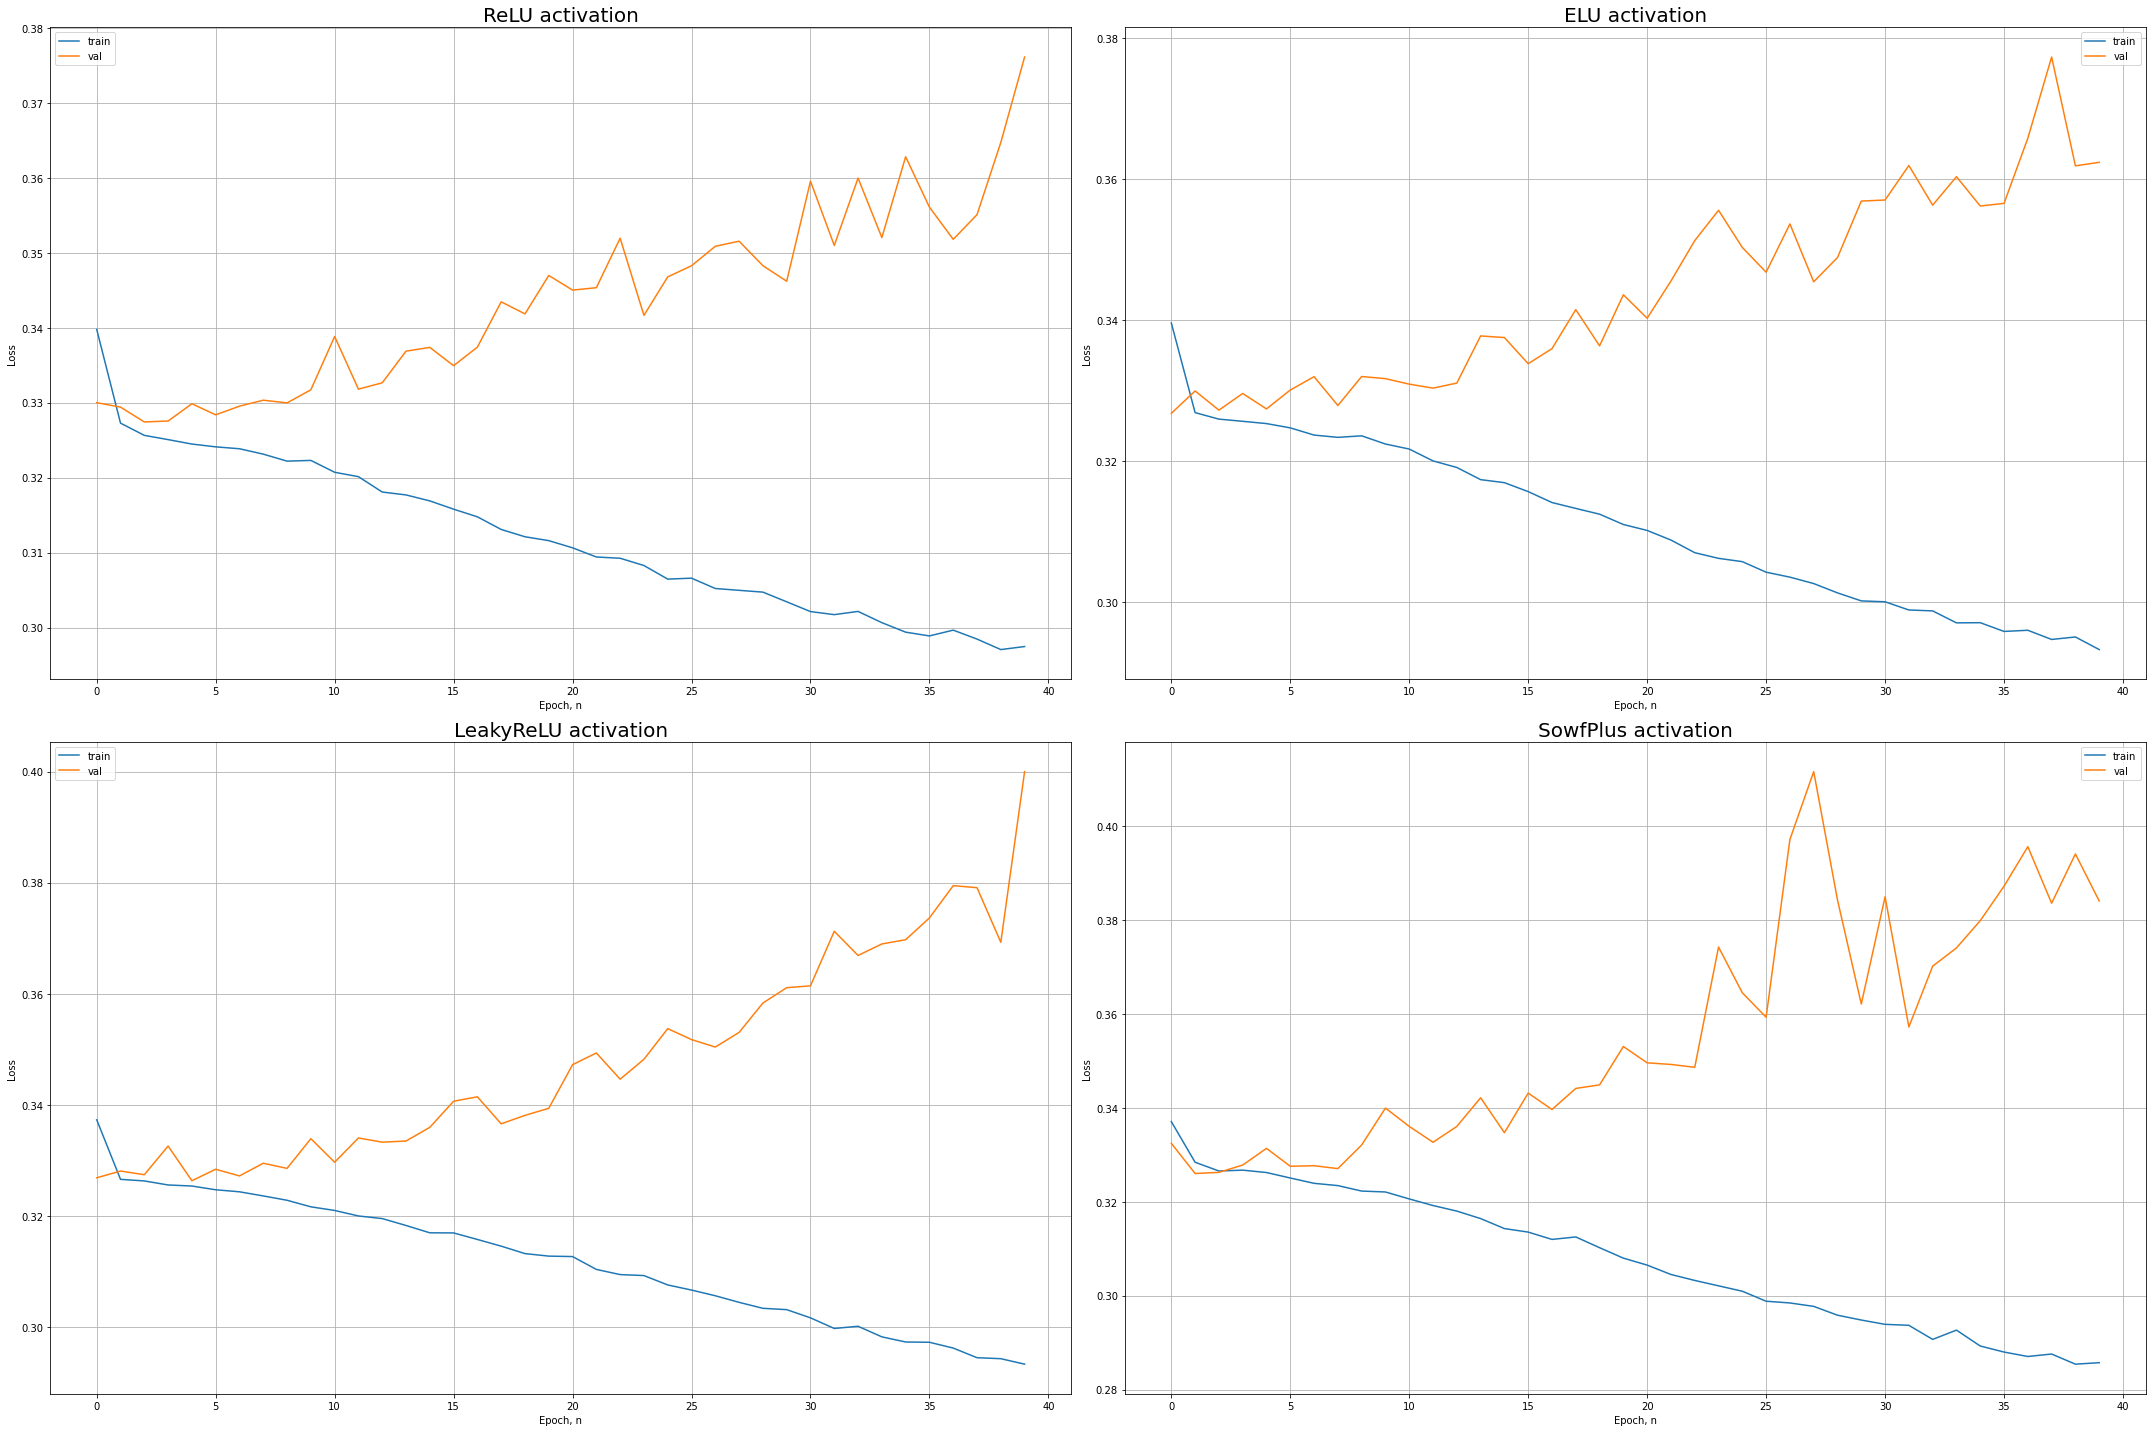

In [34]:
plt.figure(figsize=(30, 20))

# ReLU
plt.subplot(221)
plt.title("ReLU activation", fontsize=20)
_, relu_t_adam, relu_v_adam = show_train_w_batch(ReLU)

# ELU
plt.subplot(222)
plt.title("ELU activation", fontsize=20)
_, elu_t_adam, elu_v_adam = show_train_w_batch(ELU)

# LeakyReLU
plt.subplot(223)
plt.title("LeakyReLU activation", fontsize=20)
_, lrelu_t_adam, lrelu_v_adam = show_train_w_batch(LeakyReLU)

# SoftPlus
plt.subplot(224)
plt.title("SowfPlus activation", fontsize=20)
_, sp_t_adam, sp_v_adam = show_train_w_batch(SoftPlus)

plt.tight_layout()
plt.show()

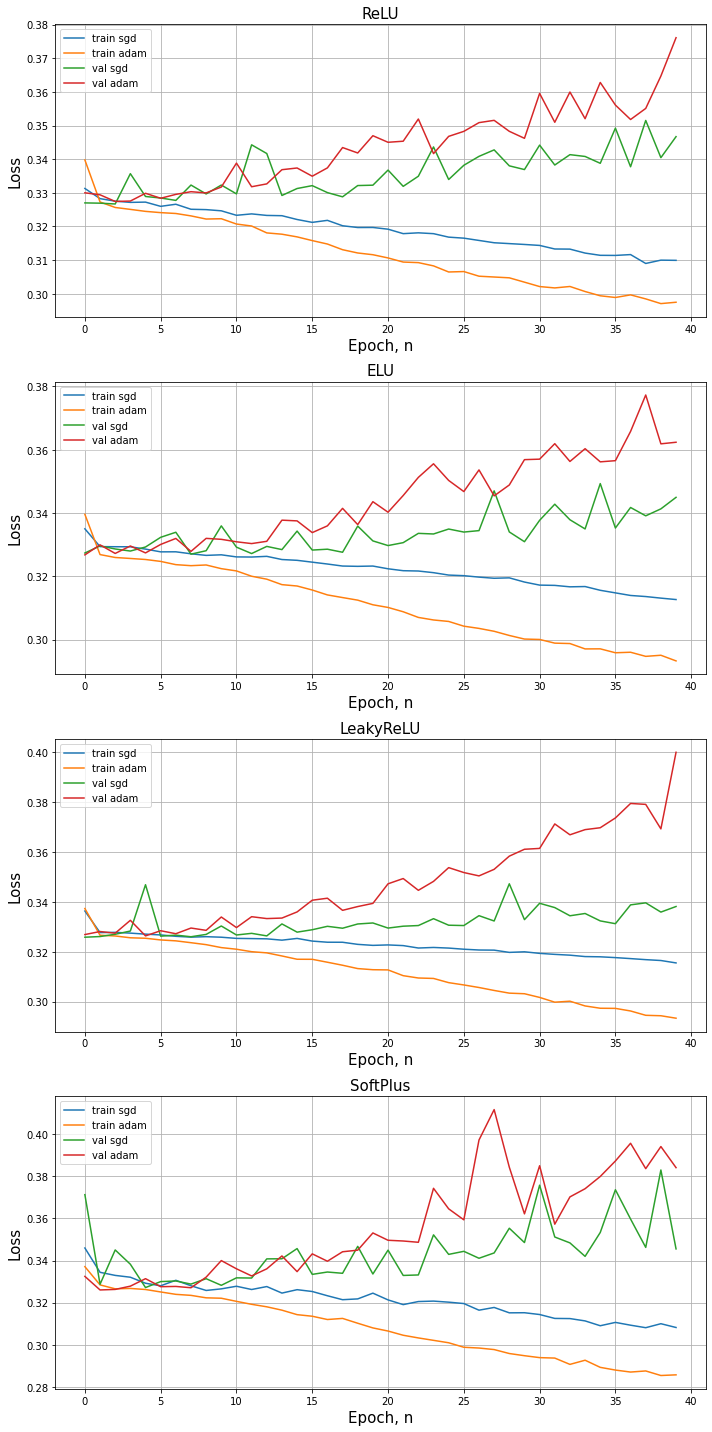

In [35]:
plt.figure(figsize=(10, 20))
plt.title("Performance w.r.t. optimizer", fontsize=20)
plt.subplot(411)
plt.title('ReLU', fontsize=15)
plt.plot(relu_t_batch, label='train sgd')
plt.plot(relu_t_adam, label='train adam')
plt.plot(relu_v_batch, label='val sgd')
plt.plot(relu_v_adam, label='val adam')
plt.xlabel('Epoch, n', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(412)
plt.title('ELU', fontsize=15)
plt.plot(elu_t_batch, label='train sgd')
plt.plot(elu_t_adam, label='train adam')
plt.plot(elu_v_batch, label='val sgd')
plt.plot(elu_v_adam, label='val adam')
plt.xlabel('Epoch, n', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(413)
plt.title('LeakyReLU', fontsize=15)
plt.plot(lrelu_t_batch, label='train sgd')
plt.plot(lrelu_t_adam, label='train adam')
plt.plot(lrelu_v_batch, label='val sgd')
plt.plot(lrelu_v_adam, label='val adam')
plt.xlabel('Epoch, n', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(414)
plt.title('SoftPlus', fontsize=15)
plt.plot(sp_t_batch, label='train sgd')
plt.plot(sp_t_adam, label='train adam')
plt.plot(sp_v_batch, label='val sgd')
plt.plot(sp_v_adam, label='val adam')
plt.xlabel('Epoch, n', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

На тренировке Adam показывает лучший результат, но на валидации ведёт себя обратным образом.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [36]:
def show_best():
    train_losses = []
    val_losses = []
    
    best_model = Sequential()
    best_model.add(Linear(n_features, 50))
    best_model.add(BatchNormalization())
    best_model.add(LeakyReLU())
    best_model.add(Dropout(p=0.6))
    best_model.add(Linear(50, 50))
    best_model.add(LeakyReLU())
    best_model.add(Dropout(p=0.6))
    best_model.add(Linear(50, n_classes))
    best_model.add(LogSoftMax())
    
    for e in range(n_epochs):
        best_model.train()
        train_losses.append(epoch(best_model, (X_train, y_train)))

        best_model.evaluate()
        val_losses.append(epoch(best_model, (X_val, y_val)))
        
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.xlabel("Epoch, n")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    
    best_model.evaluate()
    correct = 0
    for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
        predictions = best_model.forward(x_batch)
        correct += (predictions.argmax(axis=1) == y_batch.argmax(axis=1)).sum()
        
    print(correct / X_test.shape[0])

In [37]:
optimizer = adam_optimizer
optimizer_config = {'learning_rate': 1e-2, 
                         'beta1': 0.9,
                         'beta2':0.999, 
                         'epsilon':1e-8}
optimizer_state = {}
batch_size = 512

Print here your accuracy on test set. It should be around 90%.

0.9


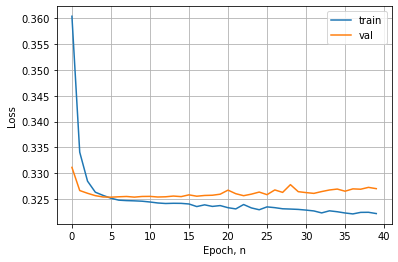

In [38]:
show_best()

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [39]:
import torch
import torch.nn as nn

Строим аналогичную модель

In [40]:
class BestModel(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(784, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(50, 10),
            nn.LogSoftmax()
        )
    
    def forward(self, inp):
        out = self.model(inp)
        return out

In [41]:
def epoch(model, data, training=True):
    model.train(training)
    
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    correct = 0.0;
    
    for x_batch, y_batch in get_batches(data, batch_size):
        
        x_batch = torch.FloatTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch.argmax(axis=1))
        
        if training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        correct += (predictions.argmax(dim=1) == y_batch.argmax(dim=1)).sum()
    
    return correct / data[0].shape[0]

In [42]:
def train_best(best_model, data):
    for _ in range(n_epochs):
        epoch(best_model, data)
        
    acc = epoch(best_model, data, training=False)
    print(acc.item())

In [43]:
model = BestModel()
train_best(model, (X_train, y_train))

/home/roman/miniconda3/envs/py3_study/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.8999999761581421
